In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# !pip3 install torchvision
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

import json

import pickle

import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from samwrapper import sam
import train
from samwrapper.example.model.smooth_cross_entropy import smooth_crossentropy
from torch.nn.utils import clip_grad_norm_

import concurrent.futures
from torch.optim.lr_scheduler import CyclicLR

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

In [55]:
permuted_datasets = []
for i in range(50):
  data = torch.tensor(train_dataset.data)
  targets = torch.tensor(train_dataset.targets)

  perm = torch.randperm(28*28)
  
  data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)
  permuted_datasets.append((data_permuted, targets))

/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_92056/2243893003.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(train_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_92056/2243893003.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_dataset.targets)


In [3]:
def create_permuted_data(original_dataset, num_tasks=50):
    permuted_datasets = []
    for i in range(num_tasks):
        data = torch.tensor(original_dataset.data)
        targets = torch.tensor(original_dataset.targets)

        perm = torch.randperm(28*28)

        data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)
        permuted_datasets.append((data_permuted, targets))
    return permuted_datasets

In [40]:
permuted_datasets = create_permuted_data(train_dataset, num_tasks=50)

/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_92056/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_92056/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


In [45]:
# permuted_datasets[3][1][2]
for batch_idx, (x,y) in enumerate(permuted_datasets):
  print(batch_idx)
  print(len(x))
  print(len(y))

# list of datasets, which are tuples (data, targets)

0
60000
60000
1
60000
60000
2
60000
60000
3
60000
60000
4
60000
60000
5
60000
60000
6
60000
60000
7
60000
60000
8
60000
60000
9
60000
60000
10
60000
60000
11
60000
60000
12
60000
60000
13
60000
60000
14
60000
60000
15
60000
60000
16
60000
60000
17
60000
60000
18
60000
60000
19
60000
60000
20
60000
60000
21
60000
60000
22
60000
60000
23
60000
60000
24
60000
60000
25
60000
60000
26
60000
60000
27
60000
60000
28
60000
60000
29
60000
60000
30
60000
60000
31
60000
60000
32
60000
60000
33
60000
60000
34
60000
60000
35
60000
60000
36
60000
60000
37
60000
60000
38
60000
60000
39
60000
60000
40
60000
60000
41
60000
60000
42
60000
60000
43
60000
60000
44
60000
60000
45
60000
60000
46
60000
60000
47
60000
60000
48
60000
60000
49
60000
60000


In [4]:
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()

        # Input layer
        self.input = nn.Linear(28*28, 100)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(3):
            self.hidden_layers.append(nn.Linear(100, 100))

        # Output layer
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.input(x))
        for i in range(3):
            x = F.relu(self.hidden_layers[i](x))
        x = self.output(x)
        return x

In [9]:
def train_1(model, optimizer, datasets, loss_fn, epochs=1):
  training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 

  model.train()
  for batch_idx, (xs, ys) in enumerate(datasets):
    print('Dataset', batch_idx)
    for epoch in range(epochs):
      data, target = xs.float(), ys.long()
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      # if epoch % 10 == 0:
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct = pred.eq(target.view_as(pred)).sum().item()
      accuracy = correct / target.size(0)
      training_data[batch_idx][epoch] = accuracy
      # if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss.item()}, Training Accuracy: {accuracy}')
  return training_data

In [9]:
def train_3_old(model, optimizer, original_dataset, loss_fn, epochs=100, test_size=0.2):
    training_data = [[0 for i in range(epochs)] for j in range(len(original_dataset))] 
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=100)
    accuracies = []
    model.train()
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                val_data, val_target = val_xs.float(), val_ys.long()
                val_output = model(val_data)
                val_pred = val_output.argmax(dim=1, keepdim=True)
                val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                val_accuracy = val_correct / val_target.size(0)
            model.train()
            training_data[batch_idx][epoch] = val_accuracy
            # print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')
        print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return training_data

In [45]:
def train_3(model, optimizer, original_dataset, loss_fn, epochs=100, test_size=0.2, num_tasks=100):    
    accuracies = []
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=num_tasks)
    model.train()
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Evaluate on the validation set
            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies

In [34]:
def train_3_optim(model, optimizer, original_dataset, loss_fn, epochs=100, test_size=0.2):
    accuracies = []
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=100)
    model.train()
    
    # Define the cyclic learning rate scheduler
    scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)
    
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Update the learning rate using the cyclic learning rate scheduler
            scheduler.step()

            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies
            

In [52]:
def full_training(train_function, original_data, loss_fn, epochs=100, test_size=0.2, runs=30, num_tasks=50):
    run_accuracies = np.empty((runs, num_tasks))
    for i in range(runs):
        model = FFNet()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        print(f'Run {i}')
        training_data = train_function(model, optimizer, original_data, loss_fn, epochs=epochs, test_size=test_size, num_tasks=num_tasks)
        run_accuracies[i] = training_data
    run_accuracies_array = np.array(run_accuracies)
    return run_accuracies_array

In [53]:
def full_training_multithread(train_function, model, optimizer, original_data, loss_fn, epochs=100, test_size=0.2, runs=10):
    run_accuracies = np.empty((runs, len(original_data)))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(runs):
            print(f'Run {i}')
            future = executor.submit(train_function, model, optimizer, original_data, loss_fn, epochs=epochs, test_size=test_size)
            futures.append(future)
            if len(futures) == 2:  # Batch size of 2 threads
                for completed_future in concurrent.futures.as_completed(futures):
                    training_data = completed_future.result()
                    training_data_array = np.array(training_data)
                    accuracies = training_data_array[:, -1]
                    run_accuracies[i-1] = accuracies
                futures = []
        # Process any remaining futures
        for completed_future in concurrent.futures.as_completed(futures):
            training_data = completed_future.result()
            training_data_array = np.array(training_data)
            accuracies = training_data_array[:, -1]
            run_accuracies[runs - len(futures):] = accuracies
    return run_accuracies

In [54]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:10000]
original_dataset.targets = original_dataset.targets[:10000]

net = FFNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_fn = F.cross_entropy
epochs = 100
test_size = 0.2
runs = 10

run_accuracies = full_training(train_3, original_dataset, loss_fn, epochs=epochs, test_size=test_size, runs=runs, num_tasks=100)
mean_accuracies = np.mean(run_accuracies, axis=0)

results = {
  "run_accuracies": run_accuracies.tolist(),
  "model_settings": {
    "model_name": "FFNet",
    "training_function": "train_3"
  }
}

# Convert the results to JSON format
json_results = json.dumps(results)

# Save the JSON object to a file
with open('results/SGD-results.json', 'w') as f:
  f.write(json_results)


Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_93560/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_93560/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset 0
Epoch: 100, Loss: 0.24340549111366272, Validation Accuracy: 0.9155
Dataset 1
Epoch: 100, Loss: 0.2479042410850525, Validation Accuracy: 0.904
Dataset 2
Epoch: 100, Loss: 0.24297727644443512, Validation Accuracy: 0.917
Dataset 3
Epoch: 100, Loss: 0.19597476720809937, Validation Accuracy: 0.905
Dataset 4
Epoch: 100, Loss: 0.2272757887840271, Validation Accuracy: 0.9105
Dataset 5
Epoch: 100, Loss: 0.21516652405261993, Validation Accuracy: 0.905
Dataset 6
Epoch: 100, Loss: 0.21604111790657043, Validation Accuracy: 0.908
Dataset 7
Epoch: 100, Loss: 0.2337370663881302, Validation Accuracy: 0.9165
Dataset 8
Epoch: 100, Loss: 0.2483288198709488, Validation Accuracy: 0.9045
Dataset 9
Epoch: 100, Loss: 0.21399642527103424, Validation Accuracy: 0.9085
Dataset 10
Epoch: 100, Loss: 0.23634324967861176, Validation Accuracy: 0.912
Dataset 11
Epoch: 100, Loss: 0.22557808458805084, Validation Accuracy: 0.9095
Dataset 12
Epoch: 100, Loss: 0.2121739238500595, Validation Accuracy: 0.925
Dataset 

KeyboardInterrupt: 

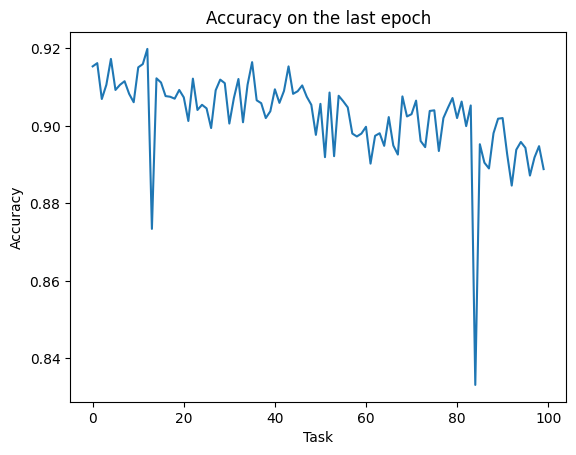

In [9]:
net = FFNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
try:
    train_data = pickle.load(open('permuted_mnist.pkl', 'rb'))
except:
    train_data = train_3(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=cross_entropy, epochs=100)

train_data_array = np.array(train_data)
accuracies = train_data_array[:, -1]

with open('permuted_mnist.pkl', 'wb') as f:
    pickle.dump(train_data_array, f)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
ax.set_xlabel('Task')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on the last epoch')
plt.show()

# Attempt SAM

### Training Functions 

In [116]:
def train_3_SAM(model, optimizer, datasets, loss_fn, epochs=1, test_size=0.2):
    training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 
    model.train()
    for batch_idx, (xs, ys) in enumerate(datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            # def closure():
            #     loss = loss_fn(model(data), target)
            #     loss.backward()
            #     return loss
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = loss_fn(output, target)
                loss.backward()
                return loss
            output = model(data)
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step(closure)
            optimizer.zero_grad()

            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                val_data, val_target = val_xs.float(), val_ys.long()
                val_output = model(val_data)
                val_pred = val_output.argmax(dim=1, keepdim=True)
                val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                val_accuracy = val_correct / val_target.size(0)
            model.train()
            training_data[batch_idx][epoch] = val_accuracy
            # print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')
        print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return training_data



In [128]:
def train_3_SAM_alt(model, optimizer, datasets, loss_fn, epochs=1, test_size=0.2,clip_grad_max_norm=1):
    training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 
    model.train()
    for batch_idx, (xs, ys) in enumerate(datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            model.train()
            data, output = train_xs.float(), train_ys.long()
            # print(model(data).size())
            # print(output.size())
            predictions = model(data)
            
            loss = loss_fn(predictions, output)
            loss.mean().backward()
            # loss.backward()
            # clip_grad_norm_(model.parameters(), clip_grad_max_norm)

            optimizer.first_step(zero_grad=True)

              # second forward-backward pass
            loss_fn(model(data), output).mean().backward()  # make sure to do a full forward pass
            # loss_fn(model(data), output).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
            
            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                val_data, val_target = val_xs.float(), val_ys.float()
                val_output = model(val_data)
                val_pred = val_output.argmax(dim=1, keepdim=True)
                val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                val_accuracy = val_correct / val_target.size(0)
            training_data[batch_idx][epoch] = val_accuracy
            # print(f' Validation Accuracy: {val_accuracy}')
            # print(f'Epoch: {epoch}, Loss: {loss}, Validation Accuracy: {val_accuracy}')

        print(f'Epoch: {epoch}, Loss: {loss}, Validation Accuracy: {val_accuracy}')

    return training_data


### Plots

Dataset 0
Epoch: 99, Loss: 0.198043555021286, Validation Accuracy: 0.9346666666666666
Dataset 1
Epoch: 99, Loss: 0.24817633628845215, Validation Accuracy: 0.9205833333333333
Dataset 2
Epoch: 99, Loss: 0.24443799257278442, Validation Accuracy: 0.9178333333333333
Dataset 3
Epoch: 99, Loss: 0.2662849724292755, Validation Accuracy: 0.9216666666666666
Dataset 4
Epoch: 99, Loss: 0.27383798360824585, Validation Accuracy: 0.9134166666666667
Dataset 5
Epoch: 99, Loss: 0.3731866776943207, Validation Accuracy: 0.8884166666666666
Dataset 6
Epoch: 99, Loss: 0.34523141384124756, Validation Accuracy: 0.8939166666666667
Dataset 7
Epoch: 99, Loss: 0.36125898361206055, Validation Accuracy: 0.8916666666666667
Dataset 8
Epoch: 99, Loss: 0.3165489435195923, Validation Accuracy: 0.91125
Dataset 9
Epoch: 99, Loss: 0.3854494094848633, Validation Accuracy: 0.8850833333333333
Dataset 10
Epoch: 99, Loss: 0.7667494416236877, Validation Accuracy: 0.7305
Dataset 11
Epoch: 99, Loss: 0.579315185546875, Validation Acc

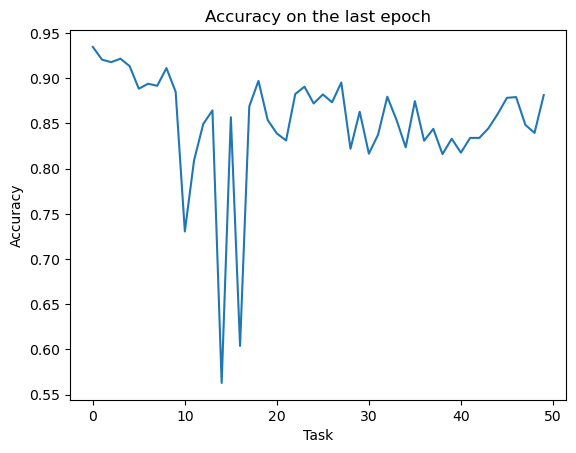

In [129]:
net = FFNet()
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# base_optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.01, momentum=0.9)
train_data = train_3_SAM_alt(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=cross_entropy, epochs=100);
# train_data = train_3_SAM(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=smooth_crossentropy, epochs=100);
train_data_array = np.array(train_data)
accuracies = train_data_array[:, -1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
ax.set_xlabel('Task')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on the last epoch')
plt.show()

In [ ]:
net = FFNet()
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# base_optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.01, momentum=0.9)
train_data = train_3_SAM(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=cross_entropy, epochs=100);
# train_data = train_3_SAM(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=smooth_crossentropy, epochs=100);
train_data_array = np.array(train_data)
accuracies = train_data_array[:, -1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
ax.set_xlabel('Task')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on the last epoch')
plt.show()

Dataset 0
